# Quick start to KinFragLib

Introduction on how to load and use the KinFragLib fragment library.

## Table of contents

1. Access fragment library
2. View all fragments of a specific inhibitor
3. Identify most common fragments in a subpocket

In [1]:
from pathlib import Path

import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools

from util import read_fragment_library, get_most_common_fragments, draw_fragmented_ligand, draw_ligands_from_pdb_ids

## 1. Access fragment library

In [2]:
# Path to library folder
PATH_TO_LIB = Path('.') / '..' / 'data' / 'fragment_library'

In [3]:
# Use utils function to read fragment library
fragment_library = read_fragment_library(PATH_TO_LIB)
fragment_library.keys()

dict_keys(['AP', 'FP', 'SE', 'GA', 'B1', 'B2', 'X'])

`fragment_library` is a dictionary containing a `pandas` DataFrame for each of the six subpockets (AP, FP, SE, GA, B1, B2) and the pool X.

For each fragment in each subpocket it contains the RDKit molecule object, the SMILES string, the kinase group, and PDB codes of the structure from which the fragment originated.

**Note**: It is also possible to load the fragment library from the `/data/fragment_library.csv` file, containing all fragments in one file, including SMILES with and without dummy atoms.

### Access fragments in specific subpocket (here AP)

In [4]:
ap_fragments = fragment_library['AP']
print('Shape of AP fragment DataFrame: ', ap_fragments.shape)
ap_fragments.head()

Shape of AP fragment DataFrame:  (2561, 11)


,ROMol,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles
0,"<img data-content=""rdkit/molecule"" src=""data:i...",AAK1,NAK,Other,5l4q,LKB,B,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,16 16 16 16 16 16 16 16 16 16 16 16 16 5 5 na na,Nc1c[nH]c2ncccc12
1,"<img data-content=""rdkit/molecule"" src=""data:i...",AAK1,NAK,Other,5te0,XIN,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 ...,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1
2,"<img data-content=""rdkit/molecule"" src=""data:i...",ABL1,Abl,TK,2f4j,VX6,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP SE,5 5 14 14 14 14 14 14 14 8 8 8 8 na,Cc1cc(N)[nH]n1
3,"<img data-content=""rdkit/molecule"" src=""data:i...",ABL1,Abl,TK,2gqg,1N1,B,A,AP AP AP AP AP AP AP AP AP AP GA SE,14 14 14 6 5 5 14 14 14 6 na na,Nc1ncc(C=O)s1
4,"<img data-content=""rdkit/molecule"" src=""data:i...",ABL1,Abl,TK,2v7a,627,,B,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,8 8 8 8 8 5 5 6 6 8 8 8 8 8 8 8 8 8 8 3 3 3 3 ...,COCC(=O)n1cc2[nH]nc(NC=O)c2c1


### Draw sample set of fragments

In [5]:
# Add molecule column to DataFrame
PandasTools.AddMoleculeColumnToFrame(ap_fragments,'smiles')

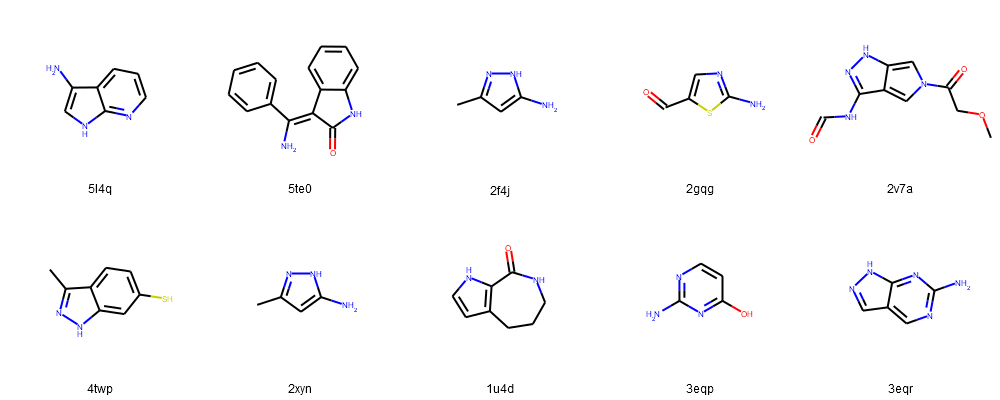

In [6]:
# Draw fragments
Draw.MolsToGridImage(ap_fragments.ROMol[:10], legends=ap_fragments.complex_pdb.to_list(), molsPerRow=5)

### Load fragments with dummy atoms

The fragments can either be loaded without dummy atoms (default), i.e. dummy atoms are replaced with hydrogens, as used above or with dummy atoms present.

In [7]:
fragment_library_dummy_atoms = read_fragment_library(PATH_TO_LIB, remove_dummy=False)

In [8]:
ap_fragments_dummy_atoms = fragment_library_dummy_atoms['AP']

In [9]:
# Add molecule column to DataFrame
PandasTools.AddMoleculeColumnToFrame(ap_fragments_dummy_atoms, 'smiles')

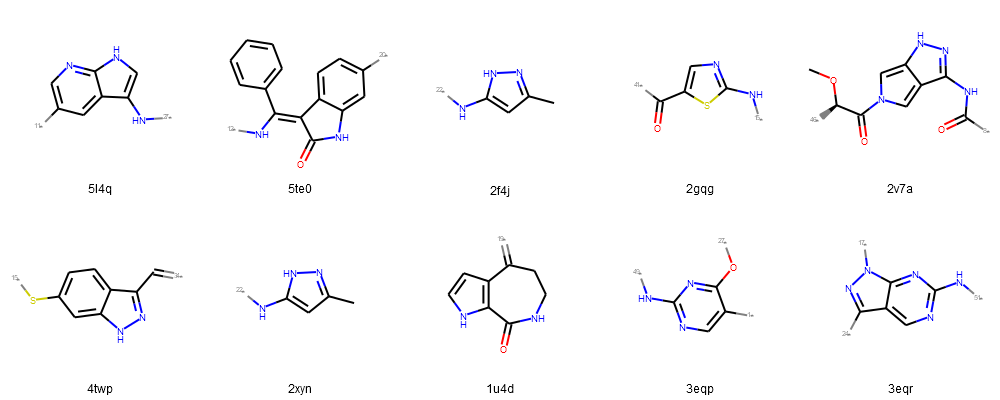

In [10]:
# Draw fragments
Draw.MolsToGridImage(ap_fragments_dummy_atoms.ROMol[:10], legends=ap_fragments_dummy_atoms.complex_pdb.to_list(), molsPerRow=5)

### Show fragments with and without dummy atoms (SMILES)

In [11]:
# Rename respective columns
ap_fragments_dummy_atoms = ap_fragments_dummy_atoms.rename(
    columns={"smiles": "smiles_dummy_atoms", "fragment": "fragment_dummy_atoms"}
)

In [12]:
# Concatenate both DataFrames
pd.concat(
    [ap_fragments, ap_fragments_dummy_atoms], 
    axis=1, 
    join='inner'
)[['smiles', 'smiles_dummy_atoms']].head()

,smiles,smiles_dummy_atoms
0,Nc1c[nH]c2ncccc12,[11*]c1cnc2[nH]cc(N[27*])c2c1
1,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1,[12*]N/C(=C1\C(=O)Nc2cc([20*])ccc21)c1ccccc1
2,Cc1cc(N)[nH]n1,[22*]Nc1cc(C)n[nH]1
3,Nc1ncc(C=O)s1,[15*]Nc1ncc(C([41*])=O)s1
4,COCC(=O)n1cc2[nH]nc(NC=O)c2c1,[8*]C(=O)Nc1n[nH]c2cn(C(=O)[C@@H]([46*])OC)cc12


## 2. View all fragments of a specific inhibitor (here Gefitinib; PDB identifier: IRE)

This analysis could be used to investigate, how different orientations/binding modi of the same molecules co-crystallized to different structures affects the subpocket assignment.

### Find IRE fragments in each subpocket

In [13]:
def get_fragments_by_ligand(ligand_pdb, fragment_library_dummy_atoms):
    """
    Get all fragments in the KinFragLib fragment library originating from a ligand of interest (by ligand PDB name).
    
    Parameters
    ----------
    ligand_pdb : str
        Ligand PDB name.
    fragment_library_dummy_atoms : dict of pandas.DataFrame
        Fragment library containing dummy atoms.
        
    Returns
    -------
    pandas.DataFrame
        Fragments originating from a ligand of interest.
    """

    fragments_by_ligand = []

    for subpocket, fragments in fragment_library_dummy_atoms.items():

        fragments_by_ligand_tmp = fragments[fragments.ligand_pdb == ligand_pdb].copy()
        fragments_by_ligand_tmp['subpocket'] = subpocket

        fragments_by_ligand.append(fragments_by_ligand_tmp)

    fragments_by_ligand = pd.concat(fragments_by_ligand)
    
    return fragments_by_ligand

In [14]:
ire_fragments = get_fragments_by_ligand('IRE', fragment_library_dummy_atoms)

print(f'Number of fragments from IRE ligands: {ire_fragments.shape[0]}')

ire_kinases = list(ire_fragments.kinase.unique())
ire_pdbs = list(ire_fragments.complex_pdb.unique())
print(f'Kinases the ligand bind to: {ire_kinases}')
print(f'Ligand co-crystallized in structures with PDB IDs: {ire_pdbs}')

Number of fragments from IRE ligands: 30
Kinases the ligand bind to: ['EGFR', 'GAK']
Ligand co-crystallized in structures with PDB IDs: ['2ito', '2ity', '2itz', '3ug2', '4i22', '4wkq', '5y7z', '5y80']


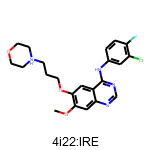

In [15]:
# Draw full ligand
draw_ligands_from_pdb_ids([ire_pdbs[4]])

### Draw sample ligand fragmentation

Draw fragments for PDB structure 2ito and ligand IRE


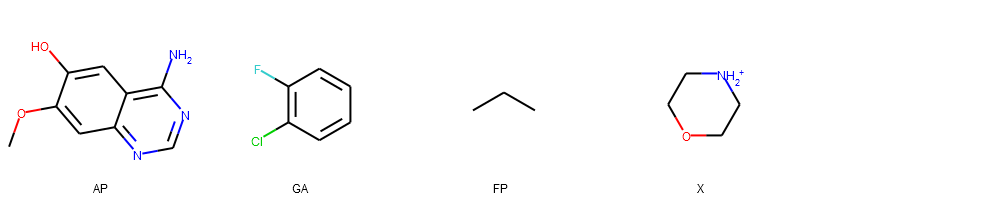

In [16]:
complex_pdb = ire_fragments.iloc[0].complex_pdb
ligand_pdb = ire_fragments.iloc[0].ligand_pdb

print(f'Draw fragments for PDB structure {complex_pdb} and ligand {ligand_pdb}')
draw_fragmented_ligand(fragment_library, complex_pdb, ligand_pdb, mols_per_row=5)

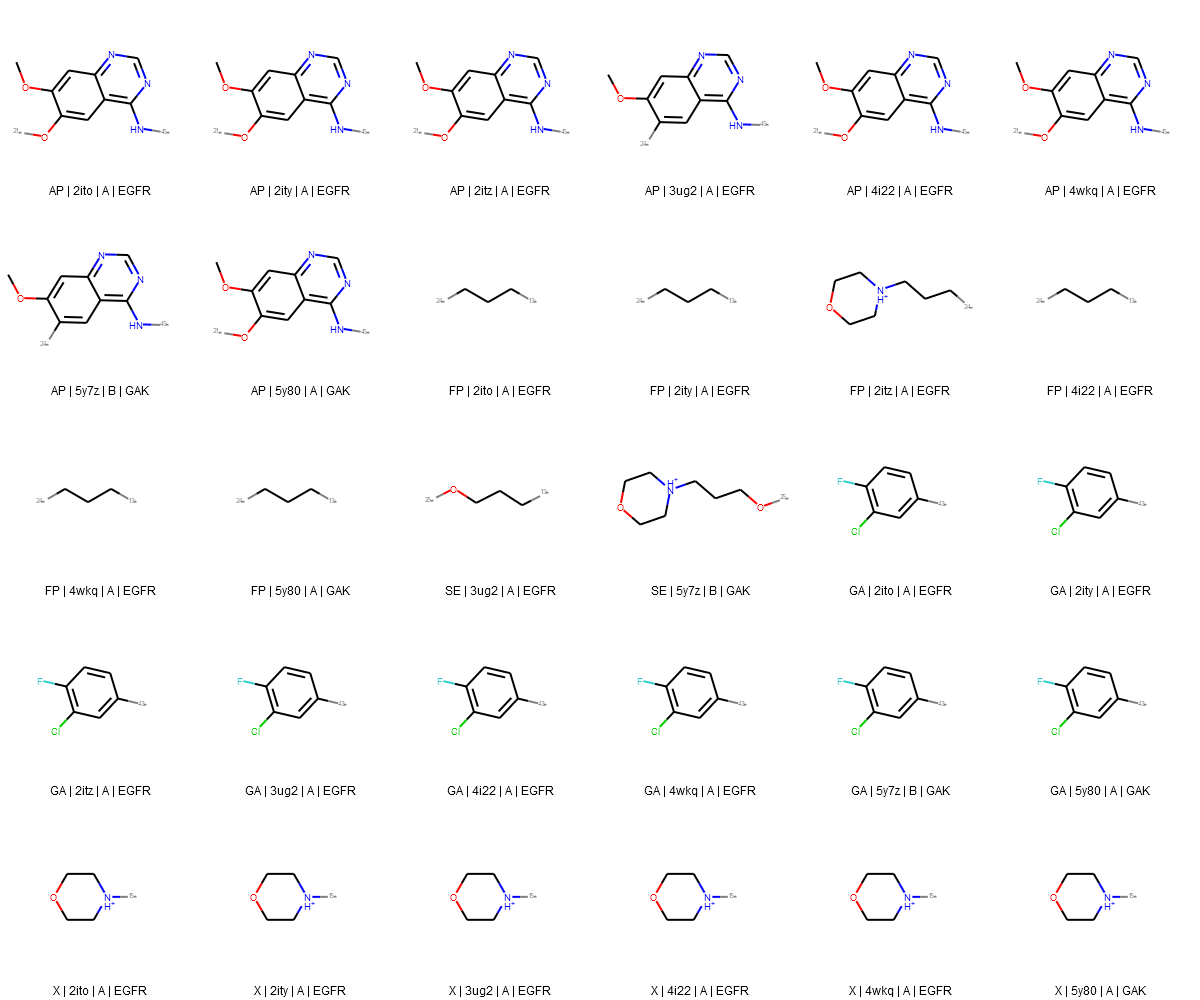

In [17]:
Draw.MolsToGridImage(
    [
        fragment.ROMol
        for index, fragment 
        in ire_fragments.iterrows()
    ], 
    legends=[
        f"{fragment.subpocket} | {fragment.complex_pdb} | {fragment.chain} | {fragment.kinase}"
        for index, fragment 
        in ire_fragments.iterrows()
    ], 
    molsPerRow=6
)

**Discussion**

The above figure shows:
* The hinge binding fragments clearly lie in AP in all structures, only difference 
    - Neighboring oxygen is in most structures part of AP
    - In some structures it was assigned to FP (3ug2, 5y7z)
* The halogenetated benzene ring is clearly assigned to GA in all structures
* In contrast the long solvent exposed tail is very flexible, and can thus, be assigned to
    - FP or SE 
    - and even be further split, with the terminal ring being annotated to pool X

## 3. Identify most common fragments in a subpocket (here AP)

In [18]:
# Use utils function to count fragment occurances
most_common_fragments_df = get_most_common_fragments(ap_fragments, top_x=25)

,molecule_id,smiles,fragment_count,ROMol
0,0,Nc1ncccn1,103,
1,1,c1ccncc1,50,
2,2,Nc1nc(N)c(C=O)s1,33,

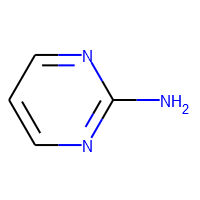
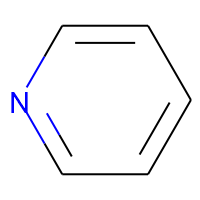
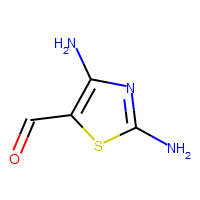

In [19]:
most_common_fragments_df.head(3)

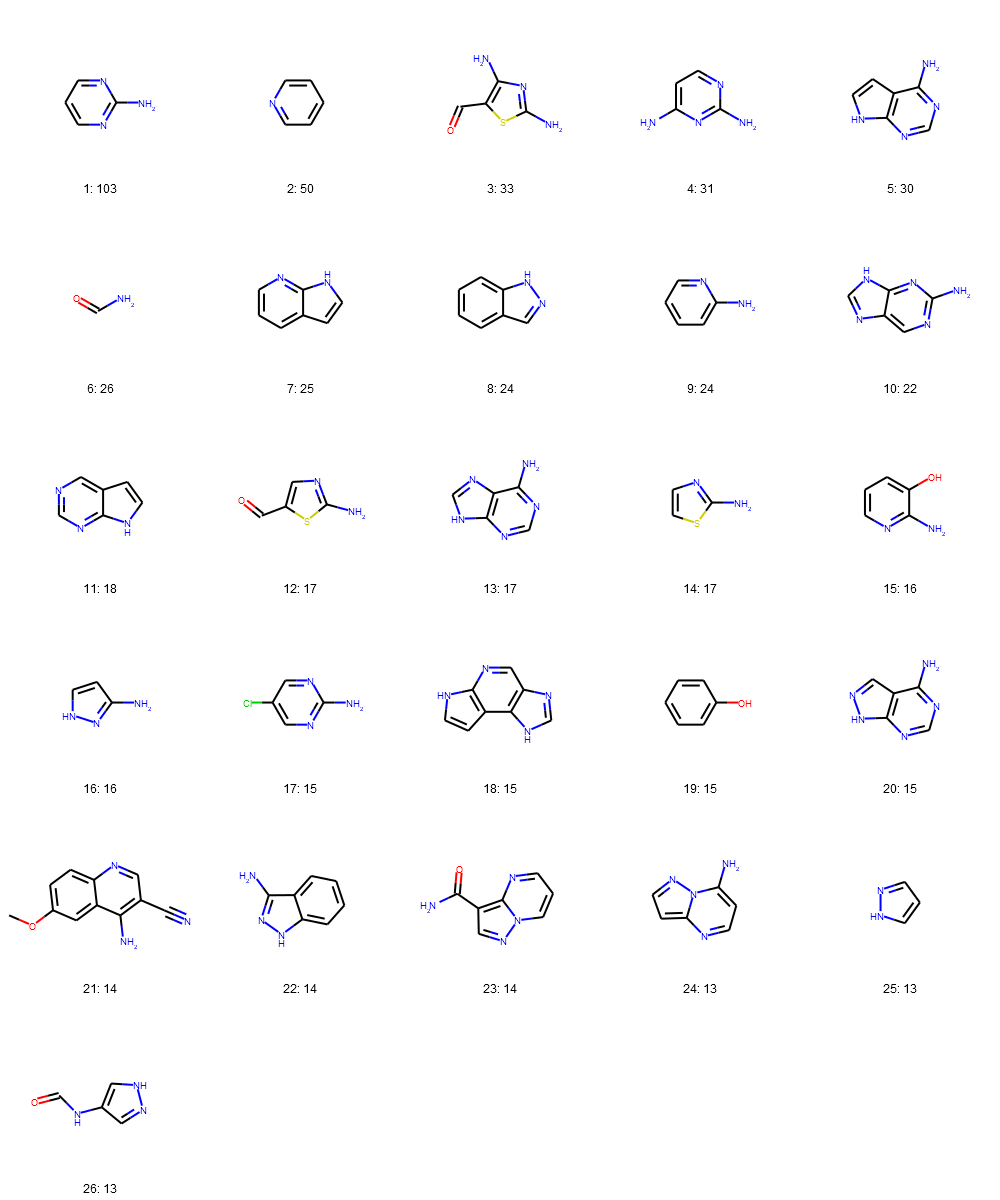

In [20]:
Draw.MolsToGridImage(
    most_common_fragments_df.ROMol, 
    legends=[f'{i+1}: {x}' for i, x in enumerate(most_common_fragments_df.fragment_count)], 
    molsPerRow=5
)

### Analyze the occurences of a specific fragment 

Select a fragment from the AP most common fragments.

In [21]:
query_smiles = Chem.MolToSmiles(most_common_fragments_df.ROMol[0])
print(query_smiles)

Nc1ncccn1


In [22]:
ap_fragments_subset = ap_fragments[ap_fragments.smiles==query_smiles]

Collect complexes containing this fragment.

In [23]:
print(f'List of pdb codes, from which the fragment originated:\n{ap_fragments_subset.complex_pdb.to_list()}')

List of pdb codes, from which the fragment originated:
['4dce', '4fnz', '6acr', '4xv2', '4xv3', '5csw', '5hie', '6gu3', '6gu7', '1h01', '1oir', '1oit', '1pxi', '1pxj', '1pxl', '1pxm', '1pxn', '1pxo', '1pxp', '1urw', '2c5n', '2c5o', '2c5v', '2uue', '2w05', '2w06', '2wev', '2xmy', '2xnb', '3ej1', '3sw4', '3sw7', '3unj', '4ek8', '4fkl', '4fko', '5iev', '5iey', '5k4j', '6gue', '6guh', '3uyt', '3uzp', '4tn6', '6gro', '4zau', '4fux', '4xj0', '5bvd', '5bve', '5bvf', '5k4i', '5ngu', '5nhf', '5nhh', '5nhj', '5nhp', '5nhv', '6gjb', '6oph', '3bz3', '3du8', '3qqu', '4d2r', '4u6r', '6dbn', '4bbe', '4bbf', '4d0w', '4d0x', '4d1s', '4hys', '4hyu', '4izy', '1pmn', '3cgo', '3kvx', '4kkh', '4u79', '3cjg', '4c3f', '4o0t', '4o0v', '4a4l', '4a4o', '5ar8', '1y57', '1xbb', '3emg', '4rss', '4xg7', '4xg9', '4yjp', '4yjq', '4yjs', '5ghv', '2x4f', '4d2s', '6dbk', '6dbm', '1bl7', '1bmk', '3fmj']


Investigate individual ligands from this set.

Draw fragments for PDB structure 4dce  and ligand 0JF


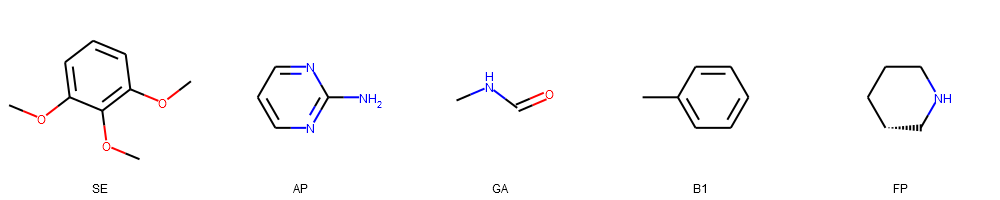

In [24]:
ap_fragments_subset_example = ap_fragments_subset.iloc[0]

pdb = ap_fragments_subset_example.complex_pdb
ligand = ap_fragments_subset_example.ligand_pdb

print('Draw fragments for PDB structure', pdb, ' and ligand', ligand)
draw_fragmented_ligand(fragment_library, pdb, ligand, mols_per_row=5)

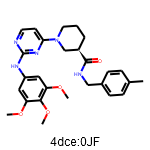

In [25]:
# Draw full ligand
draw_ligands_from_pdb_ids([pdb])